# imports

In [29]:
import pandas as pd
import numpy as np
import os
import json
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

# load data

In [30]:
import sys
sys.path.append('/home/laviniad/projects/obits/src')
sys.path.append('/home/laviniad/projects/obits')
from src.data.load_data import load_jsons_to_dataframe
from src.processing.log_odds import find_distinctive_words

In [ ]:
def infer_state_from_location(location):
    if pd.isna(location):
        return np.nan
    # split by comma and take last part
    parts = location.split(',')
    state_part = parts[-1].strip() if len(parts) > 1 else parts[0].strip()
    # take first two characters and uppercase
    state = state_part[:2].upper()
    # check if state is in list of US states
    us_states = set([
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
        'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
        'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
    ])
    if state in us_states:
        return state
    
    if state == 'DC' or state_part.upper() == 'DISTRICT OF COLUMBIA':
        return 'DC'
    
    # fall back to checking full state names
    state_names = {
        'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
        'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA',
        'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA',
        'KANSAS': 'KS', 'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
        'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS', 'MISSOURI': 'MO',
        'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ',
        'NEW MEXICO': 'NM', 'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH',
        'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
        'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT',
        'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY'
    }
    state_name_upper = state_part.upper()
    return state_names.get(state_name_upper, np.nan)

In [32]:
# load jsons from data/
DATA_PATH = '/home/laviniad/projects/obits/data/'
CLAUDE_RESPONSES = [f for f in os.listdir(DATA_PATH + 'claude_responses') if f.endswith('.json')]

obit_data = load_jsons_to_dataframe()
claude_data = []
for c in CLAUDE_RESPONSES:
    id = int(c.split('.json')[0])
    with open(DATA_PATH + 'claude_responses/' + c, 'r') as f:
        response = json.load(f)
        try:
            response = json.loads(response['response'])
        except (KeyError, json.JSONDecodeError):
            print(f"Error loading JSON for id {id}")
            response = {}
            with open('/home/laviniad/projects/obits/llm_response_broke.txt', 'a') as f:
                f.write(f"Error loading JSON for id {id}\n")
    response['id'] = id
    claude_data.append(response)

claude_data = pd.DataFrame(claude_data)
obit_data['publication_date'] = pd.to_datetime(obit_data['ObitPublishDate'], errors='coerce')
obit_data['funeral_location_state'] = obit_data['funeral_location'].apply(infer_state_from_location)

# merge with obit_data on id; if id not in claude_data, enter NaN
merged_data = obit_data.merge(claude_data, on='id', how='left', suffixes=('_obit', '_claude'))

Error loading JSON for id 43321985


# plotting

In [5]:
# style for plots!

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Create custom style dictionary
archival_style = {
    # Figure settings
    'figure.facecolor': '#f4f1e8',  # Aged paper color
    'figure.edgecolor': 'none',
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    
    # Axes settings
    'axes.facecolor': '#f4f1e8',  # Same aged paper
    'axes.edgecolor': '#3d3d3d',  # Dark charcoal
    'axes.linewidth': 0.8,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.axisbelow': True,
    'axes.labelcolor': '#2b2b2b',
    'axes.labelsize': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'normal',
    'axes.titlepad': 20,
    
    # Grid settings
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'grid.color': '#d4c4a8',  # Faded ink color
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7,
    
    # Tick settings
    'xtick.color': '#2b2b2b',
    'ytick.color': '#2b2b2b',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    
    # Font settings
    'font.family': ['serif'],
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'font.size': 15,
    'font.weight': 'normal',
    
    # Text settings
    'text.color': '#2b2b2b',
    
    # Line settings
    'lines.linewidth': 1.5,
    'lines.solid_capstyle': 'round',
    'lines.markersize': 6,
    
    # Patch settings
    'patch.linewidth': 0.5,
    'patch.facecolor': '#8b7355',
    'patch.edgecolor': '#5a4a3a',
    'patch.force_edgecolor': True,
    
    # Legend settings
    'legend.fancybox': True,
    'legend.loc': 'best',
    'legend.numpoints': 1,
    'legend.fontsize': 9,
    'legend.framealpha': 0.9,
    'legend.facecolor': '#f4f1e8',
    'legend.edgecolor': '#8b7355',
}

# Create mortality-themed color palettes
mortality_colors = [
    '#2c1810',  # Deep brown (earth/coffin)
    '#8b0000',  # Dark red (blood)
    '#4a4a4a',  # Charcoal (ash)
    '#654321',  # Dark brown (decay)
    '#800080',  # Purple (mourning)
    '#2f4f2f',  # Dark green (mold/age)
    '#191970',  # Midnight blue (night)
    '#8b4513',  # Saddle brown (leather/parchment)
]

archival_colors = [
    '#8b7355',  # Aged paper brown
    '#6b5b73',  # Faded purple ink
    '#5a6b5d',  # Old green ink
    '#7a5a4a',  # Sepia brown
    '#4a5a6b',  # Faded blue ink
    '#6b6b4a',  # Olive drab
]

# Create custom colormaps
mortality_cmap = LinearSegmentedColormap.from_list(
    'mortality', mortality_colors, N=256
)

archival_cmap = LinearSegmentedColormap.from_list(
    'archival', archival_colors, N=256
)

def apply_archival_style():
    """Apply the archival mortality style to matplotlib/seaborn"""
    # Set the style
    plt.rcParams.update(archival_style)
    
    # Set seaborn palette
    sns.set_palette(mortality_colors)
    
    print("Archival mortality style applied!")
    print("Available color palettes:")
    print("- mortality_colors: Deep, death-themed colors")
    print("- archival_colors: Aged paper and ink colors")
    print("- mortality_cmap: Continuous colormap")
    print("- archival_cmap: Continuous colormap")

def add_paper_texture(ax, intensity=0.1):
    """Add a subtle paper texture to the plot background"""
    # Create noise for paper texture
    np.random.seed(42)  # For reproducibility
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    
    # Create a grid of random noise
    x_noise = np.random.uniform(x_range[0], x_range[1], 1000)
    y_noise = np.random.uniform(y_range[0], y_range[1], 1000)
    
    # Add very faint scatter points to simulate paper grain
    ax.scatter(x_noise, y_noise, s=0.1, alpha=intensity, 
              c='#d4c4a8', marker='.', zorder=0)

def add_age_spots(ax, n_spots=5):
    """Add age spots/stains to simulate old paper"""
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    
    np.random.seed(123)  # For reproducibility
    for i in range(n_spots):
        x = np.random.uniform(x_range[0], x_range[1])
        y = np.random.uniform(y_range[0], y_range[1])
        size = np.random.uniform(0.02, 0.08)
        
        # Create irregular age spot
        circle = plt.Circle((x, y), size, color='#c8b99c', alpha=0.3, zorder=0)
        ax.add_patch(circle)

def add_mortality_watermark(ax, text="MEMENTO MORI", alpha=0.05):
    """Add a faint mortality-themed watermark"""
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            fontsize=36, weight='bold', alpha=alpha,
            ha='center', va='center', rotation=45,
            color='#8b0000', zorder=0)

# Example usage and demonstration
def create_sample_plots():
    """Create sample plots demonstrating the archival mortality style"""
    
    # Apply the style
    apply_archival_style()
    
    # Create sample data
    np.random.seed(42)
    years = np.arange(1800, 2000, 10)
    mortality_rate = 50 - (years - 1800) * 0.02 + np.random.normal(0, 3, len(years))
    
    diseases = ['Plague', 'Consumption', 'Cholera', 'Influenza', 'Typhoid']
    deaths = np.random.poisson(100, len(diseases))
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Mortality Records: A Historical Analysis', 
                fontsize=16, y=0.95, color='#2b2b2b')
    
    # Plot 1: Line plot with mortality theme
    ax1.plot(years, mortality_rate, color=mortality_colors[1], linewidth=2, 
             marker='o', markersize=4)
    ax1.set_title('Mortality Rate Over Time', pad=15)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Deaths per 1000')
    add_paper_texture(ax1, 0.05)
    add_age_spots(ax1, 3)
    
    # Plot 2: Bar plot
    bars = ax2.bar(diseases, deaths, color=mortality_colors[:len(diseases)], 
                   alpha=0.8, edgecolor='#2b2b2b', linewidth=0.8)
    ax2.set_title('Cause of Death by Disease (1890s)', pad=15)
    ax2.set_ylabel('Number of Deaths')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    add_mortality_watermark(ax2, "REQUIESCAT", 0.03)
    
    # Plot 3: Scatter plot with age spots
    ages = np.random.normal(45, 15, 100)
    lifespans = np.random.normal(65, 12, 100)
    scatter = ax3.scatter(ages, lifespans, c=ages, cmap=mortality_cmap, 
                         alpha=0.7, s=50, edgecolors='#2b2b2b', linewidth=0.5)
    ax3.set_title('Age vs Lifespan Analysis', pad=15)
    ax3.set_xlabel('Age at Last Census')
    ax3.set_ylabel('Final Lifespan')
    add_age_spots(ax3, 4)
    
    # Plot 4: Histogram
    life_expectancy = np.random.gamma(2, 30, 1000)
    ax4.hist(life_expectancy, bins=30, color=mortality_colors[3], 
             alpha=0.7, edgecolor='#2b2b2b', linewidth=0.8)
    ax4.set_title('Distribution of Life Expectancy', pad=15)
    ax4.set_xlabel('Years of Life')
    ax4.set_ylabel('Frequency')
    add_paper_texture(ax4, 0.08)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig

In [6]:
PLOT_DIR = '/home/laviniad/projects/obits/plots/'

def save_plot(fig, filename):
    """Save the plot to a file"""
    fig.savefig(f'{PLOT_DIR}{filename}.pdf', dpi=300, bbox_inches='tight')

In [43]:
# print lines in merged_data where funeral_location_state is NaN but funeral_location is not NaN
print(merged_data[pd.isna(merged_data['funeral_location_state']) & ~pd.isna(merged_data['funeral_location'])][['id', 'funeral_location']])

# dump to file
with open('/home/laviniad/projects/obits/funeral_location_state_issues.txt', 'w') as f:
    for index, row in merged_data[pd.isna(merged_data['funeral_location_state']) & ~pd.isna(merged_data['funeral_location'])][['id', 'funeral_location']].iterrows():
        f.write(f"ID: {row['id']}, Location: {row['funeral_location']}\n")

            id                                   funeral_location
35    29946340       4303 Pleasant Valley Road, Vernon, BC V1T4M4
39    31070011         96 St Andrews Street, Cambridge, ON N1S1M8
64    43027888      77 Blackwood Road, Sunderland , Tyne and Wear
77    45587858                 Neville House, Luton, Bedfordshire
236   43058938                        103 Norma Road, Myaree 6154
...        ...                                                ...
4876  41100105                  7313 Highway 26, Stayner, Ontario
4877  40420227            400 Dominion Road, Mount Eden, Auckland
4961   3739706  4925 Nannie Helen Burroughs Avenue, N.E., Wash...
5018  20508928         614 First Street East, Cornwall, ON K6H1M1
5100  45421040                 1251 Doveton Street, Ballarat 3350

[122 rows x 2 columns]


In [33]:
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 26.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 25.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.3 MB/s eta 0:00:00


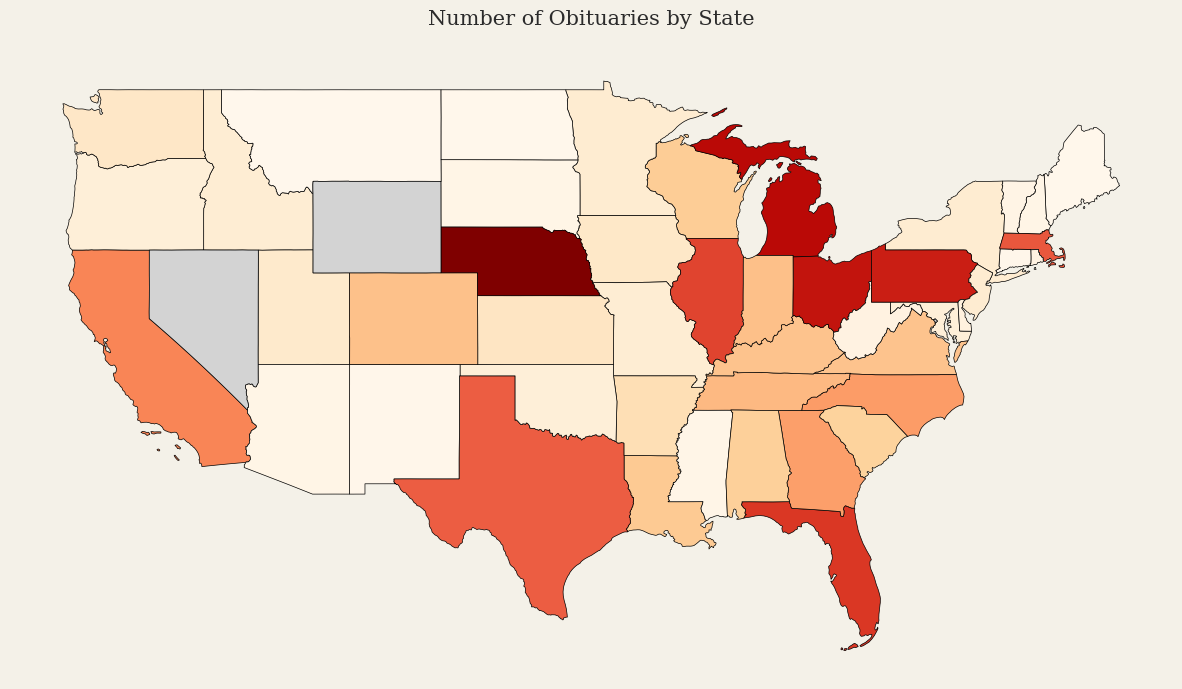

In [41]:
import geopandas as gpd

# Get United States only (this gives the whole US as one geometry)
us_states = gpd.read_file("/home/laviniad/projects/obits/data/cb_2021_us_state_20m")
# Remove non-states (like Puerto Rico and territories)
us_states = us_states[~us_states['STUSPS'].isin(['PR', 'VI', 'GU', 'MP', 'AS', 'AK', 'HI'])]

state_counts = obit_data['funeral_location_state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']

# Merge state counts with geometries
# Merge on state abbreviation (STUSPS is 2-letter code)
merged = us_states.merge(state_counts, how='left', left_on='STUSPS', right_on='state')

# Plot choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='count',
            ax=ax,
            legend=False,
            cmap='OrRd',
            edgecolor='black',
            missing_kwds={
                "color": "lightgrey",
                "label": "No data"
            })
plt.title("Number of Obituaries by State", fontsize=15)
plt.axis('off')
plt.show()


Archival mortality style applied!
Available color palettes:
- mortality_colors: Deep, death-themed colors
- archival_colors: Aged paper and ink colors
- mortality_cmap: Continuous colormap
- archival_cmap: Continuous colormap


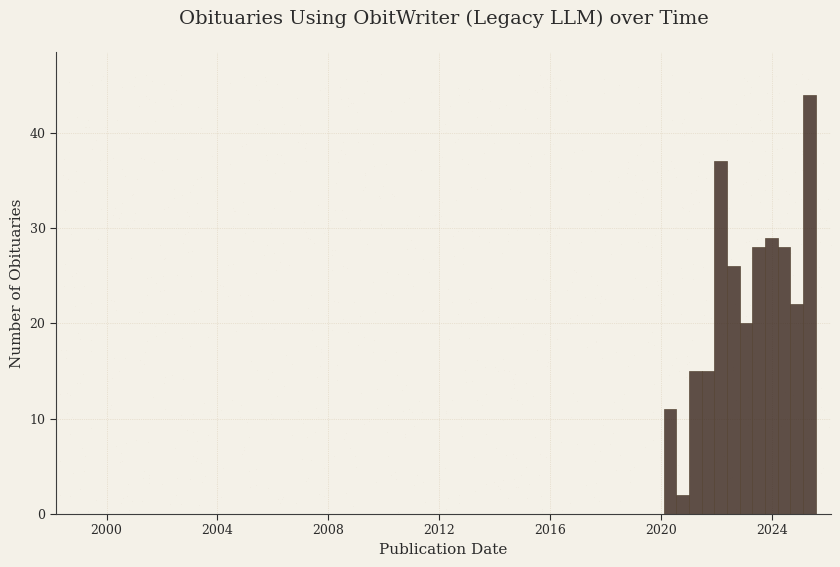

In [7]:
# plot time of publication for non-null ObitwriterSource rows
apply_archival_style()
obitwriter_used = obit_data[obit_data['ObitwriterSource'] != '']


fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(obitwriter_used['publication_date'], bins=12, kde=False, ax=ax)
ax.set_title('Obituaries Using ObitWriter (Legacy LLM) over Time')
ax.set_xlim(obit_data['publication_date'].min(), obit_data['publication_date'].max())
ax.set_xlabel('Publication Date')
add_paper_texture(ax, 0.1)
ax.set_ylabel('Number of Obituaries')
# save figure
save_plot(fig, 'obitwriter_usage_over_time')
plt.show()

In [8]:
# what are distinctive words in obits with obitwriter source vs without?

with_obitwriter = obit_data[obit_data['ObitwriterSource'] != '']['text'].tolist()
without_obitwriter = obit_data[obit_data['ObitwriterSource'] == '']['text'].tolist()

distinctive_words = find_distinctive_words(with_obitwriter, without_obitwriter, top_n=20, log_odds_alpha=1, filter_stopwords_etc=True)
print("Top distinctive words in obits WITH ObitwriterSource:")
print(distinctive_words['corpus_a'])
print("\nTop distinctive words in obits WITHOUT ObitwriterSource:")
print(distinctive_words['corpus_b'])

Building vocabulary...


/home/laviniad/miniconda3/envs/classifier/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0a5', '0be', '0hq', '0m0', '0x201c', '0x201d', '101b', '10am', '10h30', '10k', '10th', '11a', '121a', '12noon', '130a', '133d', '15910w', '159th', '19th', '1a3', '1ae', '1b1', '1eh', '1ez', '1ht', '1j8', '1jf', '1l0', '1n6', '1ng', '1qe', '1qh', '1qs', '1rn', '1y9', '1yb', '1z6', '1z7', '2004it', '2006remembering', '2008milton', '2009who', '2013following', '2019patterson', '20b', '25a', '25pm', '25th', '2ba', '2bj', '2c3', '2db', '2ea', '2el', '2ez', '2g7', '2k', '2l3', '2le', '2lh', '2p6', '2qd', '2r3', '2rt', '2rx', '2sp', '2xa', '2y6', '2z0', '3090b', '30pm', '3a0', '3ap', '3b', '3d', '3de', '3e', '3ew', '3hd', '3hx', '3l7', '3m', '3n6', '3pq', '3s371', '3w', '408b', '4b', '4bq', '4g3', '4h', '4hl', '4hs', '4m', '4pm', '5ar', '5b3', '5bj', '5bs', '5dh', '5h

Calculating distinctive words...
Top distinctive words in obits WITH ObitwriterSource:
['betenbaugh' 'wilde' 'crisman' 'plude' 'carswell' 'sonoras' 'withrow'
 'paglia' 'gervin' 'lacaze' 'colantro' 'natyniak' 'hornell' 'nest'
 'orahood' 'gillham' 'remie' 'handel' 'beideman' 'leet']

Top distinctive words in obits WITHOUT ObitwriterSource:
['lewis' 'rogers' 'lorraine' 'hartford' 'turner' 'vernon' 'centre'
 'oklahoma' 'jay' 'nelson' 'idaho' 'murphy' 'korean' 'fla' 'arizona' 'aug'
 'feb' 'oct' 'sept' 'nov']


In [20]:
obit_data['NoticeType'].value_counts()

NoticeType
premium                         4558
legacy_pro_basic                 262
legacy_pro_business              108
DignityMemorialObituary          104
funeral_home_local_spotlight      78
funeral_home_obit                 55
consumer_obit                     16
death_notice_obit_only            15
Name: count, dtype: int64

In [22]:
# produce latex table of FirstToFile x AdStatus
pd.crosstab(obit_data['FirstToFile'], obit_data['AdStatus'], margins=True).to_latex('firsttofile_x_adstatus.tex')

In [47]:
merged_data['occupation'].value_counts().head(20).to_latex('top_20_occupations.tex')

In [52]:
merged_data['cause_of_death'].value_counts()

cause_of_death
None                                                                                                                                                                             4489
passed away suddenly                                                                                                                                                               10
passed away unexpectedly                                                                                                                                                            8
Passed away peacefully                                                                                                                                                              6
died suddenly                                                                                                                                                                       6
                                                                           

Archival mortality style applied!
Available color palettes:
- mortality_colors: Deep, death-themed colors
- archival_colors: Aged paper and ink colors
- mortality_cmap: Continuous colormap
- archival_cmap: Continuous colormap


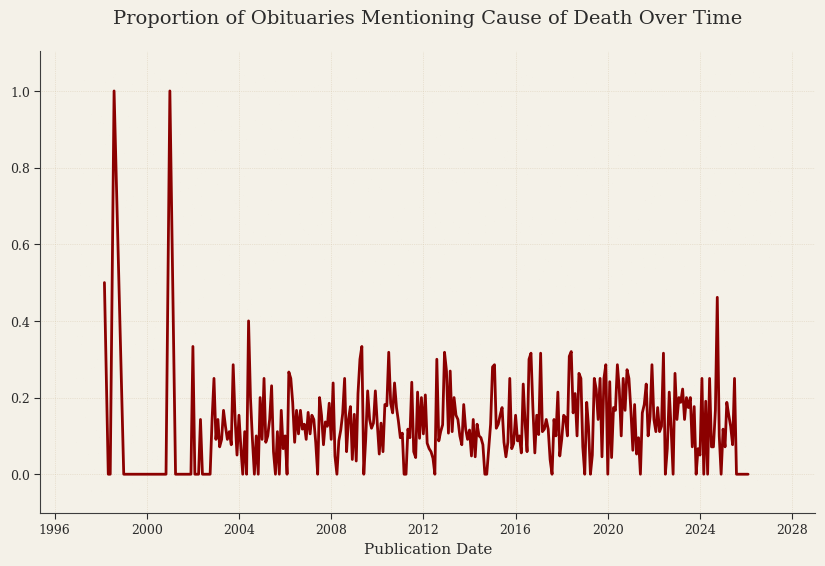

In [56]:
# plot proportion of obits which mention cause of death over time
apply_archival_style()
fig, ax = plt.subplots(figsize=(10,6))
# group by year-month and calculate proportion of non-null cause_of_death
merged_data['year_month'] = merged_data['publication_date'].dt.to_period('M')
merged_data = merged_data[merged_data['cause_of_death'].notna()]
merged_data['mentions_cause_of_death'] = merged_data['cause_of_death'].apply(lambda x: 1 if pd.notna(x) and x != 'None' else 0)
prop_cause_of_death = merged_data.groupby('year_month')['mentions_cause_of_death'].mean()
prop_cause_of_death.index = prop_cause_of_death.index.to_timestamp()
ax.plot(prop_cause_of_death.index, prop_cause_of_death.values, color=mortality_colors[1], linewidth=2)
ax.set_title('Proportion of Obituaries Mentioning Cause of Death Over Time')
ax.set_xlabel('Publication Date')
add_paper_texture(ax, 0.05) 
save_plot(fig, 'proportion_mentioning_cause_of_death_over_time')
plt.show()

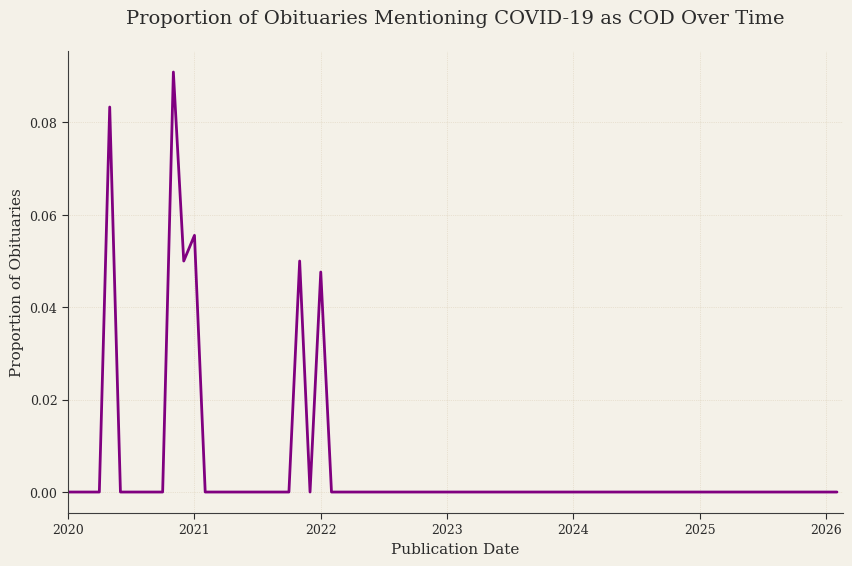

In [70]:
def mentions_covid(x):
    if pd.isna(x):
        return 0
    x_lower = x.lower()
    if 'covid' in x_lower or 'coronavirus' in x_lower or 'pandemic' in x_lower or 'sars-cov-2' in x_lower:
        return 1
    return 0

def mentions_drugs_and_alcohol(x):
    if pd.isna(x):
        return 0
    x_lower = x.lower()
    if 'drug' in x_lower or 'alcohol' in x_lower or 'overdose' in x_lower or 'substance' in x_lower or 'addict' in x_lower:
        return 1
    return 0

merged_data['mentions_covid'] = merged_data['cause_of_death'].apply(mentions_covid)
merged_data['mentions_drugs_and_alcohol'] = merged_data['cause_of_death'].apply(mentions_drugs_and_alcohol)
fig, ax = plt.subplots(figsize=(10,6))
covid_mentions = merged_data.groupby('year_month')['mentions_covid'].mean()
covid_mentions.index = covid_mentions.index.to_timestamp()
#drug_alcohol_mentions = merged_data.groupby('year_month')['mentions_drugs_and_alcohol'].mean()
#drug_alcohol_mentions.index = drug_alcohol_mentions.index.to_timestamp()
ax.plot(covid_mentions.index, covid_mentions.values, color=mortality_colors[4], linewidth=2)
plt.xlim(pd.to_datetime('2020-01-01'), merged_data['publication_date'].max())
#ax.plot(drug_alcohol_mentions.index, drug_alcohol_mentions.values, color=mortality_colors[5], linewidth=2)
ax.set_title('Proportion of Obituaries Mentioning COVID-19 as COD Over Time')
ax.set_xlabel('Publication Date')
ax.set_ylabel('Proportion of Obituaries')
# save figure
save_plot(fig, 'proportion_covid_cause_of_death_over_time')
plt.show()

Archival mortality style applied!
Available color palettes:
- mortality_colors: Deep, death-themed colors
- archival_colors: Aged paper and ink colors
- mortality_cmap: Continuous colormap
- archival_cmap: Continuous colormap


AttributeError: Rectangle.set() got an unexpected keyword argument 'hue'

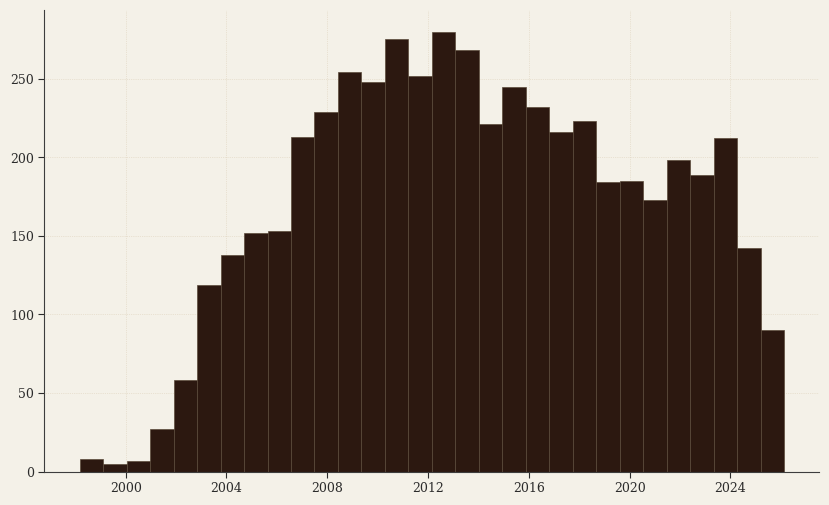

In [ ]:
# plot number of obits over time!

adsOk = obit_data[obit_data['ObitwriterSource'] != '']

apply_archival_style()
plt.hist(obit_data['publication_date'], bins=30)
plt.hist(merged_data['publication_date'], bins=30, alpha=0.7, label='All Obits')
plt.title('Number of Obituaries Over Time')
plt.xlabel('Publication Date')
plt.ylabel('Number of Obituaries')
# save
save_plot(plt.gcf(), 'number_of_obits_over_time')
plt.show()